# ECE420 iCard Scanner

In [170]:
# Import libraries
import cv2
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

In [171]:
# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
def dist_point_line(x1, y1, x2, y2, x0, y0):
    return ((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

# Function that returns the contour of the largest rectangular object in the frame
def get_bounding_quadrangle(img):
    kernel = np.ones((3,3), np.uint8)
    img_dilate = cv2.dilate(img, kernel, iterations=1)
    # cv2.imshow("Dilate", img_dilate)
    
    # Perform Canny Edge detection
    img_edgedetect = cv2.Canny(img_dilate, threshold1=100, threshold2=200)
#     cv2.imshow('Edges', img_edgedetect)
    
    # Get Contours 
    img_contours, hierarchy = cv2.findContours(img_edgedetect, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_contours = np.ones_like(img, dtype=np.uint8) * 255
    
    max_area = 0
    max_idx = -1
    
    for idx, contour in enumerate(img_contours):
        contour_convex_hull = cv2.convexHull(contour)
        convex_hull_area = cv2.contourArea(contour_convex_hull)
        # print(contour_convex_hull)
        
        if(max_area < convex_hull_area):
            max_idx = idx
            max_area = convex_hull_area
    
    if (max_idx >= 0):
        cv2.drawContours(img_with_contours, [img_contours[max_idx]], 0, (0,255,0), 2)
        # cv2.imshow('Contours no hull', img_with_contours)
        cv2.drawContours(img_with_contours, [cv2.convexHull(img_contours[max_idx])], 0, (0,255,0), 2)
#         cv2.imshow('Contours', img_with_contours)
    else:
        print("No max contour found")
        return -1
        
    # Apply polygon approximation
    for err in np.linspace(0.005, 0.09, 80):
        approx_contour = cv2.approxPolyDP(cv2.convexHull(img_contours[max_idx]), err * cv2.arcLength(img_contours[max_idx], True), True)
        # print(f"err: {err}, numpt: {approx_contour.shape}")
        if(approx_contour.shape[0] == 4):
            break
    
    return (approx_contour, cv2.convexHull(img_contours[max_idx]))

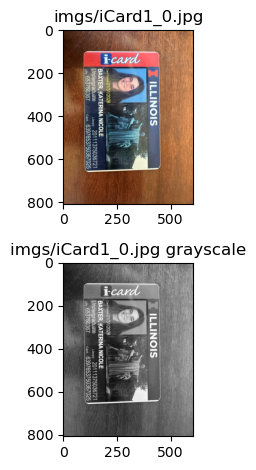

In [172]:
# Import 
IMG_DIR  = 'imgs/'
IMG_NAME = 'iCard1_0.jpg'

img_color = cv2.imread(f"{IMG_DIR}{IMG_NAME}")
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.subplot(211)
plt.imshow(img_color[:,:,::-1])
plt.title(f"{IMG_DIR}{IMG_NAME}")
plt.subplot(212)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title(f"{IMG_DIR}{IMG_NAME} grayscale")
plt.tight_layout()

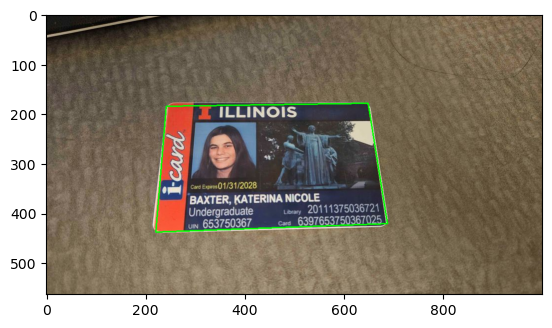

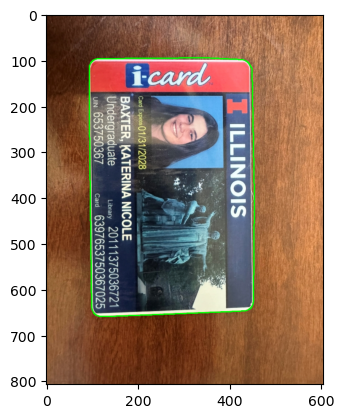

In [173]:
approx_contour, orig_contours = get_bounding_quadrangle(img)
img_poly_contour_approx = img_color.copy()
img_poly_contour_orig = img_color.copy()
cv2.drawContours(img_poly_contour_approx, [approx_contour], -1, (0,255,0), 2)
cv2.drawContours(img_poly_contour_orig, [orig_contours], -1, (0,255,0), 2)


plt.figure()
plt.imshow(img_poly_contour[:,:,::-1])
plt.figure()
plt.imshow(img_poly_contour_orig[:,:,::-1])

[[453 397]] -> [[448 119]]: 278.044960393099
[[347  95]] -> [[111  97]]: 236.00847442411893
[[ 94 222]] -> [[ 96 409]]: 187.0106948813356
[[218 656]] -> [[318 652]]: 100.07996802557443
[[453 397 448 119]
 [347  95 111  97]
 [ 94 222  96 409]
 [218 656 318 652]]
slope ratio[1]: 0.9998475795634678
slope ratio[2]: 0.6816546762589928
slope ratio[3]: 0.9992805755395684
Slope arr: [ 5.56000000e+01 -8.47457627e-03  9.35000000e+01 -4.00000000e-02]
yint arr: [-24789.8            97.94067797  -8567.            664.72      ]
opp idx: 2
Corners: [[447  63]
 [457 619]
 [ 98 596]
 [ 92  35]]


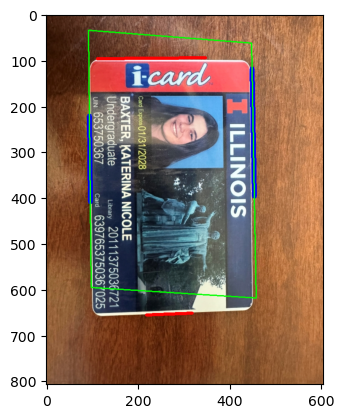

In [179]:
img_poly_contour_longest_lines = img_color.copy()

# can use L1 (manhanttan distance) instead of L2 norm (euclidean) since only need ranking, not actual
# Saves 2 squares and 1 sqrt
distances = orig_contours - np.roll(orig_contours, 1, axis=0)
distances = np.linalg.norm(distances, axis=2).flatten()

corners = np.zeros((4,2), dtype=np.int32)
slope_array = np.zeros(4)
y_int_array = np.zeros(4)

# 4 lines, each one is (x1,y1,x2,y2)
lines = np.zeros((4,4), dtype=np.int32)

next_line = 0

COLINEAR_CUTOFF = 10

for i in range(len(distances)):
    max_idx = np.argsort(distances)[-(i+1)]
    
    # Save the line endpoints
    lines[next_line][0:2] = orig_contours[max_idx][0]
    lines[next_line][2:4] = orig_contours[max_idx-1][0]
    
    slope_denom = (lines[next_line][2]-lines[next_line][0])
    if (slope_denom == 0):
        slope = (lines[next_line][3]-lines[next_line][1]) / 0.00001
    else:
        slope = (lines[next_line][3]-lines[next_line][1]) / slope_denom
        
    y_int = lines[next_line][1] - slope * lines[next_line][0]
    
    # Check if colinear with a line already in our set
    colinear = False
    for j in range(next_line):
        if (dist_point_line(*(lines[j]), lines[next_line][0], lines[next_line][1]) < COLINEAR_CUTOFF and 
            dist_point_line(*(lines[j]), lines[next_line][2], lines[next_line][3]) < COLINEAR_CUTOFF):
            colinear = True
            break
        
    
    if(not colinear):
        print(f"{orig_contours[max_idx]} -> {orig_contours[max_idx - 1]}: {distances[max_idx]}")
        slope_array[next_line] = slope
        y_int_array[next_line] = y_int

        next_line += 1
        if(next_line == 4):
            break
    
print(lines)

# Find equations for each line

# for i in range(4):
#     slope_array[i] = (lines[i][3]-lines[i][1]) / (lines[i][2]-lines[i][0])
#     y_int_array[i] = lines[i][1] - slope_array[i] * lines[i][0]

# Find 1 pair of opposite sides (idx 0 and its opposite side)
if(np.abs(slope_array[0]) < 0.001):
    slope_array[0] = 0.001
    
opposite_idx = 1
slope_ratio = np.abs(np.abs(slope_array[1] / slope_array[0]) - 1)
print(F"slope ratio[1]: {slope_ratio}")

for i in range(2,4):
    new_slope_ratio = np.abs(np.abs(slope_array[i] / slope_array[0]) - 1)
    print(F"slope ratio[{i}]: {new_slope_ratio}")
    if(new_slope_ratio < slope_ratio):
        slope_ratio = new_slope_ratio
        opposite_idx = i
        
# Find 2 corners next to side 0
if(opposite_idx == 1):
    adj_idx = np.array((2,3))
elif(opposite_idx == 2):
    adj_idx = np.array((1,3))
else:
    adj_idx = np.array((1,2))

for i in range(2):
    corners[i][0] = (y_int_array[adj_idx[i]] - y_int_array[0]) / (slope_array[0] - slope_array[adj_idx[i]])
    corners[i][1] = slope_array[0] * corners[i][0] + y_int_array[0]
    corners[3-i][0] = (y_int_array[adj_idx[i]] - y_int_array[opposite_idx]) / (slope_array[opposite_idx] - slope_array[adj_idx[i]])
    corners[3-i][1] = slope_array[opposite_idx] * corners[3-i][0] + y_int_array[opposite_idx]

print(f"Slope arr: {slope_array}")
print(f"yint arr: {y_int_array}")
print(f"opp idx: {opposite_idx}")

    
for i in range(4):
    cv2.line(img_poly_contour_longest_lines, lines[i][0:2], lines[i][2:4], (0, 0, 255), 5)
    if(i == 0 or i == opposite_idx):
        cv2.line(img_poly_contour_longest_lines, lines[i][0:2], lines[i][2:4], (255, 0, 0), 10)
    cv2.line(img_poly_contour_longest_lines, corners[i], corners[i-1], (0, 255, 0), 2)
    
print(f"Corners: {corners}")

plt.imshow(img_poly_contour_longest_lines[:,:,::-1])